# Transformer Network Application: Question Answering


## Table of Contents


- [1 - Extractive Question Answering](#1)
    - [1.1 - Data Cleaning](#1-1)
    - [1.2 - Tokenize and Align Labels](#1-2)
- [2 - Training](#2)
- [3 - Evaluation](#3)
   


<a name='1'></a>
## 1 - Extractive Question Answering

Question answering (QA) is a task of natural language processing that aims to automatically answer questions. The goal of *extractive* QA is to identify the portion of the text that contains the answer to a question. For example, when tasked with answering the question 'When will Jane go to Africa?' given the text data 'Jane visits Africa in September', the question answering model will highlight 'September'.

<a name='1-1'></a>
### 1.1 - Data preprocessing

 load the [QA bAbI dataset](https://research.fb.com/downloads/babi/), which is one of the bAbI datasets generated by Facebook AI Research to advance natural language processing.

In [9]:
from datasets import load_from_disk

# Load a dataset and print the first example in the training set
babi_dataset = load_from_disk('data/')
print(babi_dataset['train'][0])

{'story': {'answer': ['', '', 'office'], 'id': ['1', '2', '3'], 'supporting_ids': [[], [], ['1']], 'text': ['The office is north of the kitchen.', 'The garden is south of the kitchen.', 'What is north of the kitchen?'], 'type': [0, 0, 1]}}


 For a given story, there are two sentences which serve as the context, and one question. Each of these phrases has an ID. There is also a supporting fact ID which refers to a sentence in the story that helps answer the question. For example, for the question 'What is east of the hallway?', the supporting fact 'The bedroom is east of the hallway' has the ID '2'. There is also the answer, 'bedroom' for the question.

In [10]:
babi_dataset['train'][102]

{'story': {'answer': ['', '', 'bedroom'],
  'id': ['1', '2', '3'],
  'supporting_ids': [[], [], ['2']],
  'text': ['The bedroom is west of the office.',
   'The bedroom is east of the hallway.',
   'What is east of the hallway?'],
  'type': [0, 0, 1]}}

In [11]:
type_set = set()
for story in babi_dataset['train']:
    if str(story['story']['type'] )not in type_set:
        type_set.add(str(story['story']['type'] ))

In [12]:
type_set

{'[0, 0, 1]'}

To make the data easier to work with, we will flatten the dataset to transform it from a dictionary structure to a table structure.

In [13]:
flattened_babi = babi_dataset.flatten()

In [14]:
flattened_babi

DatasetDict({
    train: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'],
        num_rows: 1000
    })
})

In [15]:
next(iter(flattened_babi['train']))

{'story.answer': ['', '', 'office'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The office is north of the kitchen.',
  'The garden is south of the kitchen.',
  'What is north of the kitchen?'],
 'story.type': [0, 0, 1]}

we can now easily extract the answer, question, and facts from the story, and also join the facts into a single entry under 'sentences'.

In [16]:
def get_question_and_facts(story):
    dic = {}
    dic['question'] = story['story.text'][2]
    dic['sentences'] = ' '.join([story['story.text'][0], story['story.text'][1]])
    dic['answer'] = story['story.answer'][2]
    return dic

In [17]:
processed = flattened_babi.map(get_question_and_facts)

In [18]:
processed['train'][2]

{'story.answer': ['', '', 'bedroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['2']],
 'story.text': ['The garden is north of the office.',
  'The bedroom is north of the garden.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The garden is north of the office. The bedroom is north of the garden.',
 'answer': 'bedroom'}

In [19]:
processed['test'][2]

{'story.answer': ['', '', 'bathroom'],
 'story.id': ['1', '2', '3'],
 'story.supporting_ids': [[], [], ['1']],
 'story.text': ['The bathroom is north of the garden.',
  'The hallway is north of the bathroom.',
  'What is north of the garden?'],
 'story.type': [0, 0, 1],
 'question': 'What is north of the garden?',
 'sentences': 'The bathroom is north of the garden. The hallway is north of the bathroom.',
 'answer': 'bathroom'}

The goal of extractive QA is to find the part of the text that contains the answer to the question. We will identify the position of the answer using the indexes of the string. For example, if the answer to some question was 'September', you would need to find the start and end string indices of the word 'September' in the context sentence 'Jane visits Africa in September.'

In [20]:
def get_start_end_idx(story):
    str_idx = story['sentences'].find(story['answer'])
    end_idx = str_idx + len(story['answer'])
    return {'str_idx':str_idx,
          'end_idx': end_idx}

In [21]:
processed = processed.map(get_start_end_idx)

In [22]:
num = 187
print(processed['test'][num])
start_idx = processed['test'][num]['str_idx']
end_idx = processed['test'][num]['end_idx']
print('answer:', processed['test'][num]['sentences'][start_idx:end_idx])

{'story.answer': ['', '', 'garden'], 'story.id': ['1', '2', '3'], 'story.supporting_ids': [[], [], ['2']], 'story.text': ['The hallway is south of the garden.', 'The garden is south of the bedroom.', 'What is south of the bedroom?'], 'story.type': [0, 0, 1], 'question': 'What is south of the bedroom?', 'sentences': 'The hallway is south of the garden. The garden is south of the bedroom.', 'answer': 'garden', 'str_idx': 28, 'end_idx': 34}
answer: garden


<a name='1-2'></a>
### 1.2 - Tokenize and Align

 To feed text data to a Transformer model, we will need to tokenize our input using a [🤗 Transformer tokenizer](https://huggingface.co/transformers/main_classes/tokenizer.html). It is crucial that the tokenizer we use must match the Transformer model type we are using! we will use the 🤗 [DistilBERT fast tokenizer](https://huggingface.co/transformers/model_doc/distilbert.html), which standardizes the length of our sequence to 512 and pads with zeros.

Transformer models are often trained by tokenizers that split words into subwords. For instance, the word 'Africa' might get split into multiple subtokens. This can create some misalignment between the list of tags for the dataset and the list of labels generated by the tokenizer, since the tokenizer can split one word into several, or add special tokens. Before processing, it is important that we align the start and end indices with the tokens associated with the target answer word with a `tokenize_and_align()` function. In this case, since we are interested in the start and end indices of the answer, we will want to align the index of the sentence to match the index of the token for a word.


In [23]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('tokenizer/')

In [24]:
def tokenize_align(example):
    encoding = tokenizer(example['sentences'], example['question'], truncation=True, padding=True, max_length=tokenizer.model_max_length)
    start_positions = encoding.char_to_token(example['str_idx'])
    end_positions = encoding.char_to_token(example['end_idx']-1)
    if start_positions is None:
        start_positions = tokenizer.model_max_length
    if end_positions is None:
        end_positions = tokenizer.model_max_length
    return {'input_ids': encoding['input_ids'],
          'attention_mask': encoding['attention_mask'],
          'start_positions': start_positions,
          'end_positions': end_positions}

In [25]:
qa_dataset = processed.map(tokenize_align)

In [26]:
qa_dataset = qa_dataset.remove_columns(['story.answer', 'story.id', 'story.supporting_ids', 'story.text', 'story.type'])

In [27]:
qa_dataset['train'][200]

{'question': 'What is north of the bathroom?',
 'sentences': 'The garden is north of the bathroom. The hallway is south of the bathroom.',
 'answer': 'garden',
 'str_idx': 4,
 'end_idx': 10,
 'input_ids': [101,
  1996,
  3871,
  2003,
  2167,
  1997,
  1996,
  5723,
  1012,
  1996,
  6797,
  2003,
  2148,
  1997,
  1996,
  5723,
  1012,
  102,
  2054,
  2003,
  2167,
  1997,
  1996,
  5723,
  1029,
  102],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'start_positions': 2,
 'end_positions': 2}

In [30]:
print('sentences : ',qa_dataset['train'][200]['sentences'])
print('question : ',qa_dataset['train'][200]['question'])
print('answer : ',qa_dataset['train'][200]['answer'])
print('str_idx : ',qa_dataset['train'][200]['str_idx'])
print('end_idx : ',qa_dataset['train'][200]['end_idx'])
print('start_positions : ',qa_dataset['train'][200]['start_positions'])
print('end_positions : ',qa_dataset['train'][200]['end_positions'])
print('input_ids : ',qa_dataset['train'][200]['input_ids'])
print('attention_mask : ',qa_dataset['train'][200]['attention_mask'])

sentences :  The garden is north of the bathroom. The hallway is south of the bathroom.
question :  What is north of the bathroom?
answer :  garden
str_idx :  4
end_idx :  10
start_positions :  2
end_positions :  2
input_ids :  [101, 1996, 3871, 2003, 2167, 1997, 1996, 5723, 1012, 1996, 6797, 2003, 2148, 1997, 1996, 5723, 1012, 102, 2054, 2003, 2167, 1997, 1996, 5723, 1029, 102]
attention_mask :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<a name='2'></a>
# 2 - Training

we willfeed it into a pre-trained Transformer model,DistilBERT model, which matches the tokenizer we used to preprocess our data.

In [31]:
train_ds = qa_dataset['train']
test_ds = qa_dataset['test']

In [39]:
from transformers import TFDistilBertForQuestionAnswering
model = TFDistilBertForQuestionAnswering.from_pretrained("model/tensorflow", return_dict=False)

Some layers from the model checkpoint at model/tensorflow were not used when initializing TFDistilBertForQuestionAnswering: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForQuestionAnswering were not initialized from the model checkpoint at model/tensorflow and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



#### Train and test datasets

**Note:**
* In the TensorFlow implementation, we will have to set the data format type to tensors, which may create ragged tensors (tensors of different lengths).
* we will have to convert the ragged tensors to normal tensors using the `to_tensor()` method, which pads the tensors and sets the dimensions to `[None, tokenizer.model_max_length]` so we can feed different size tensors into our model based on the batch size.  

In [33]:
import tensorflow as tf
# Tokenize and align the test dataset
columns_to_return = ['input_ids','attention_mask', 'start_positions', 'end_positions']

train_ds.set_format(type='tf', columns=columns_to_return)
train_features = {x: train_ds[x] for x in ['input_ids', 'attention_mask']}
train_labels = {"start_positions": tf.reshape(train_ds['start_positions'], shape=[-1,1]),
                'end_positions': tf.reshape(train_ds['end_positions'], shape=[-1,1])}
train_tfdataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(8)

test_ds.set_format(type='tf', columns=columns_to_return)
test_features = {x: test_ds[x] for x in ['input_ids', 'attention_mask']}
test_labels = {"start_positions": tf.reshape(test_ds['start_positions'], shape=[-1,1]),
               'end_positions': tf.reshape(test_ds['end_positions'], shape=[-1,1])}
test_tfdataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(8)

#### Training



In [34]:
EPOCHS = 3
loss_fn1 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy( from_logits=True)
opt = tf.keras.optimizers.Adam(learning_rate=3e-5)

losses = []
for epoch in range(EPOCHS):
    print("Starting epoch: %d"% epoch )
    for step, (x_batch_train, y_batch_train) in enumerate(train_tfdataset):
        with tf.GradientTape() as tape:
            answer_start_scores, answer_end_scores = model(x_batch_train)
            loss_start = loss_fn1(y_batch_train['start_positions'], answer_start_scores)
            loss_end = loss_fn2(y_batch_train['end_positions'], answer_end_scores)
            loss = 0.5 * (loss_start + loss_end)
        losses.append(loss)
        grads = tape.gradient(loss, model.trainable_weights)
        opt.apply_gradients(zip(grads, model.trainable_weights))

        if step % 20 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step,
                                                                   float(loss_start)))


Starting epoch: 0
Training loss (for one batch) at step 0: 3.3658
Training loss (for one batch) at step 20: 1.2483
Training loss (for one batch) at step 40: 0.5979
Training loss (for one batch) at step 60: 0.6204
Training loss (for one batch) at step 80: 0.5239
Training loss (for one batch) at step 100: 0.0897
Training loss (for one batch) at step 120: 0.5419
Starting epoch: 1
Training loss (for one batch) at step 0: 0.6697
Training loss (for one batch) at step 20: 0.2518
Training loss (for one batch) at step 40: 0.5088
Training loss (for one batch) at step 60: 0.3311
Training loss (for one batch) at step 80: 0.1339
Training loss (for one batch) at step 100: 0.0931
Training loss (for one batch) at step 120: 0.4563
Starting epoch: 2
Training loss (for one batch) at step 0: 0.3080
Training loss (for one batch) at step 20: 0.0840
Training loss (for one batch) at step 40: 0.5056
Training loss (for one batch) at step 60: 0.2976
Training loss (for one batch) at step 80: 0.1219
Training loss 

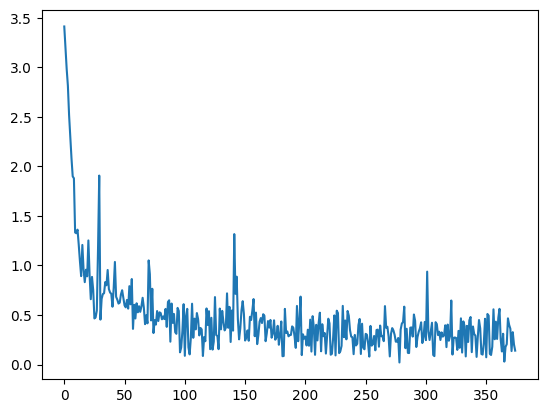

In [35]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

## 3 - Evaluation

Try asking it a question about a story.

In [38]:
question, text = 'What is south of the bedroom?','The hallway is south of the garden. The garden is south of the bedroom.'
input_dict = tokenizer(text, question, return_tensors='tf')
outputs = model(input_dict)
start_logits = outputs[0]
end_logits = outputs[1]

all_tokens = tokenizer.convert_ids_to_tokens(input_dict["input_ids"].numpy()[0])
answer = ' '.join(all_tokens[tf.math.argmax(start_logits, 1)[0] : tf.math.argmax(end_logits, 1)[0]+1])
print(question, answer.capitalize())

What is south of the bedroom? Garden


In [ ]:
# Evaluate the model on the test dataset
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
for step, (x_batch_test, y_batch_test) in enumerate(test_tfdataset):
    answer_start_scores, answer_end_scores = model(x_batch_test)
    accuracy.update_state(y_batch_test['start_positions'], answer_start_scores)
    accuracy.update_state(y_batch_test['end_positions'], answer_end_scores)

print("Accuracy on test dataset:", accuracy.result().numpy())

Accuracy on test dataset: 0.7875
